# Final Project: Sarcasm Detection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk

from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers

## Introduction

Sarcasm has been part of human language for a very long time. However, understanding sarcasm can vary from human to human.    In this project, we are going to train a machine learning model using deep learning to detect whether a news headline is sarcastic or not. The dataset is taken from Kaggle (https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection) and consists of two json files with a collection of headlines each. Each dataset contains 2 features, article_link and headline, and the target variable with label values of 0(non-sarcastic) or 1(sarcastic). The dataset is mainly collected from two news website, *TheOnion* and *HuffPost*. Headlines from the *TheOnion* are sarcastic while the ones from *HuffPost* are non-sarcastic. We will be using Natural Language Processing (NLP) techniques to help machines read the text and provide a sentiment analysis on the headline texts.

We will join the two datasets together and delete duplicate headlines from the concatenated dataset so that we will have more headlines for training the model later. The concatenated dataset is in the shape(55328, 3). The final dataset is in the shape(28617, 3).

In [2]:
#Load Datasets
df1 = pd.read_json('./Sarcasm_Headlines_Dataset.json', lines = True)
df2 = pd.read_json('./Sarcasm_Headlines_Dataset_v2.json', lines = True)

In [3]:
#Combine Datasets
sarcasm_df = pd.concat([df1, df2], axis = 0)

In [4]:
sarcasm_df.shape

(55328, 3)

In [5]:
sarcasm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55328 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  55328 non-null  object
 1   headline      55328 non-null  object
 2   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [6]:
sarcasm_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## Data Cleaning and Exploratory Data Analysis

Before we start with EDA, let's check the data for missing values and duplicates.

In [7]:
#Check missing values
sarcasm_df.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [8]:
#Check duplicated values
sarcasm_df.duplicated().sum()

26711

In [9]:
#Remove duplicated values
sarcasm_df.drop_duplicates(inplace=True)

There are no missing values, but there are duplicated values in the dataset. This is probably because we combined both datasets and caused some overlapping between datasets. We removed the duplicated values. We will also remove the feature 'article_link' as it is not useful for our analysis. We only require the headlines for our analysis.

In [10]:
# Dropping the column article-link since it is not useful for our analysis
sarcasm_df.drop('article_link', axis = 1, inplace = True)

In [11]:
sarcasm_df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


### Brief EDA

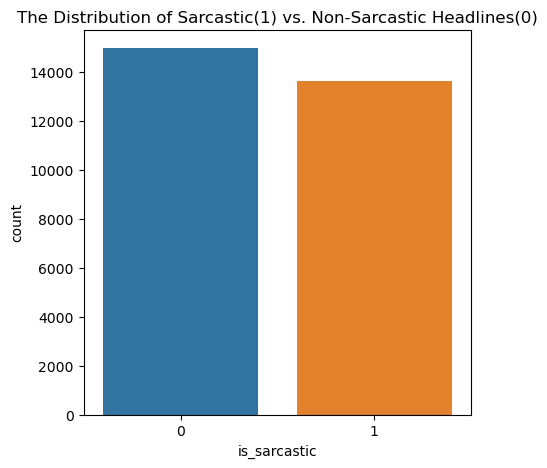

In [12]:
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.countplot(x = sarcasm_df['is_sarcastic'])
plt.title("The Distribution of Sarcastic(1) vs. Non-Sarcastic Headlines(0)")
plt.show()

In [13]:
print('Target distribution(%):') 
print(np.round(sarcasm_df['is_sarcastic'].value_counts(normalize=True)*100, 2))

Target distribution(%):
0    52.36
1    47.64
Name: is_sarcastic, dtype: float64


From the above graph and target distribution percentage, we can see that the data seems relatively balanced.

Let's see the text content for a sarcastic and non_sarcastic headline.

In [14]:
#Sarcastic Tweets
sarcastic_tweets = sarcasm_df[sarcasm_df['is_sarcastic']==1]['headline']
print(sarcastic_tweets.values[0])
print(sarcastic_tweets.values[1])
print(sarcastic_tweets.values[2])
print(sarcastic_tweets.values[3])

mom starting to fear son's web series closest thing she will have to grandchild
boehner just wants wife to listen, not come up with alternative debt-reduction ideas
top snake handler leaves sinking huckabee campaign
nuclear bomb detonates during rehearsal for 'spider-man' musical


In [15]:
#Non-Sarcastic Tweets
non_sarcastic_tweets = sarcasm_df[sarcasm_df['is_sarcastic']==0]['headline']
print(non_sarcastic_tweets.values[0])
print(non_sarcastic_tweets.values[1])
print(non_sarcastic_tweets.values[2])
print(non_sarcastic_tweets.values[3])

former versace store clerk sues over secret 'black code' for minority shoppers
the 'roseanne' revival catches up to our thorny political mood, for better and worse
j.k. rowling wishes snape happy birthday in the most magical way
advancing the world's women


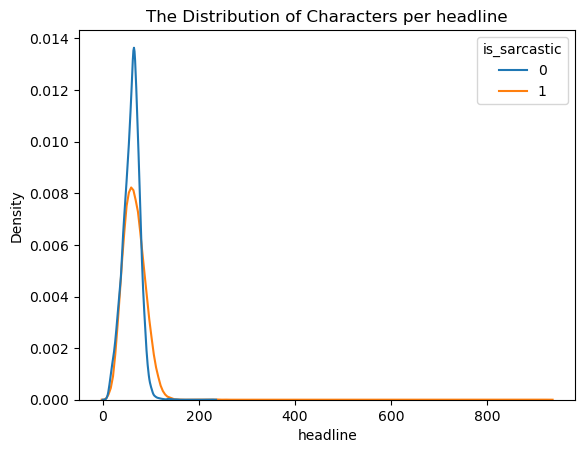

In [16]:
# Visualizing number of characters in each headline
fig, ax = plt.subplots()
ax = sns.kdeplot(sarcasm_df, x = sarcasm_df['headline'].str.len(), hue = 'is_sarcastic')
plt.title("The Distribution of Characters per headline")
plt.show()

From the graph above, it seems that there more characters in non-sarcastic headlines.

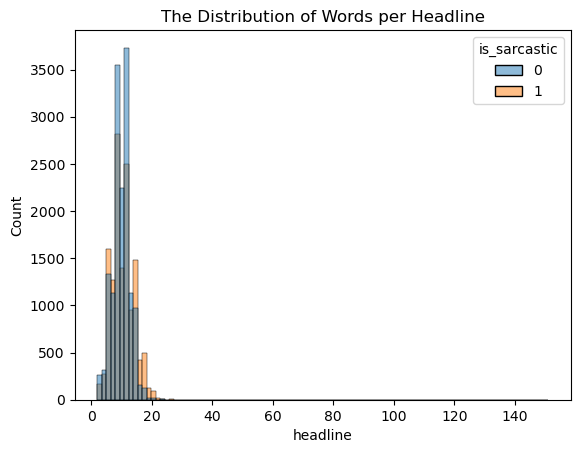

In [17]:
# Visualizing number of words in each Category
sarcasm_df['headline'].str.split().map(lambda x: len(x))

fig, ax = plt.subplots()
ax = sns.histplot(sarcasm_df, x = sarcasm_df['headline'].str.split().map(lambda x: len(x)), hue = 'is_sarcastic', bins = 100)
plt.title("The Distribution of Words per Headline")
plt.show()

There are more words in non-sarcastic headlines than sarcastic headlines.

## Text Preprocessing

Before we can build our model, we need to process the text of the headlines. This can be achieved by using NLP techniques on the text. First, we will make sure all the text is in lowercase and then, we will remove special characters such as hashtags etc. After that, we will remove stopwords. Here, the stopwords are commonly used words in English. By removing them, we can focus on more important words in the text.

In [18]:
#Lowercase all text
sarcasm_df['headline'] = sarcasm_df['headline'].str.lower()

#Remove numeric and special characters, including punctuation
sarcasm_df['headline'] = sarcasm_df['headline'].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
sarcasm_df['headline'] = sarcasm_df['headline'].apply(lambda row: re.sub(r'[0-9]', '', row))

In [19]:
#Remove stopwords
stopwords = nltk.corpus.stopwords.words('english')

sarcasm_df['headline'] = sarcasm_df['headline'].apply(lambda words: ' '.join(word for word in words.split() if word not in stopwords))

Next, we will tokenize and lemmatize the text.

Tokenization is a technique to break down sentences into a stream of words called tokens. This can be used for further analysis or in other methods for natural language processing.

Lemmatization is text preprocessing technique similar to stemming since they can be used to convert words into their root form. Lemmatization is more advanced since it actually transforms the word to its actual root by using a dictionary. Because it tries to be more accurate, it requires more processing power and time to generate an output. 

Since these headlines are written by news professionals, it is expected that there are no spelling mistakes or informal language use. This will be easier for lemmatization.

In [20]:
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatizer(text):
    tokens = nltk.word_tokenize(text)
    lem_text = ' '.join([wordnet_lemmatizer.lemmatize(w) for w in tokens])
    return lem_text

In [21]:
sarcasm_df['headline'] = sarcasm_df['headline'].apply(lemmatizer)

In [22]:
sarcasm_df['headline'].head()

0    former versace store clerk sue secret black co...
1    roseanne revival catch thorny political mood b...
2    mom starting fear son web series closest thing...
3    boehner want wife listen come alternative debt...
4     jk rowling wish snape happy birthday magical way
Name: headline, dtype: object

## Model Architecture

For our Deep Learning project, we will be using Recurrent Neural Networks for text classification. We previously used RNN models for classifying disaster and non-disaster tweets. 

We need to create word embeddings. A word embedding is a NLP approach where individual words are represented as real-value vectors. Each word can be represented by a vector with hundreds or thousands of dimensions. For creating word embedding, we will use the Embedding Layer provided by Keras. The Embedding Layer can be used to train our own embeddings. It enables us to convert each word into a fixed length vector of defined size.

The requirement is that the input text data should be numerical encoded, so that each word is represented by a unique integer. This can be prepared by using the keras.Tokenizer.

In [23]:
X = sarcasm_df['headline']
y = sarcasm_df['is_sarcastic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=41)

In [24]:
t = Tokenizer(num_words = 10000)
t.fit_on_texts(X_train)

In [25]:
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)
print(encoded_train[0:2])

[[76, 1054, 1230, 1670, 601, 1765, 863, 31, 3150], [1400, 3775, 4800, 751, 6615, 971, 8423, 1957, 6]]


In [26]:
max_length = max([len(i) for i in encoded_train])
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post', truncating='post')
print(padded_train)

[[  76 1054 1230 ...    0    0    0]
 [1400 3775 4800 ...    0    0    0]
 [1671 2515    0 ...    0    0    0]
 ...
 [   1  745  584 ...    0    0    0]
 [ 123  203 2421 ...    0    0    0]
 [ 698 5980  214 ...    0    0    0]]


In [27]:
vocab_size = len(t.word_index) + 1
# define model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, output_dim = 100, input_length = max_length))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)))
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# compile model
model.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(2e-4), metrics = ['accuracy'])

# summarize model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 99, 100)           2256400   
                                                                 
 bidirectional (Bidirectiona  (None, 99, 64)           34048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,  mode='min')

#fit model
history = model.fit(padded_train,y_train, validation_data=(padded_test,y_test), epochs = 100, callbacks=[early_stopping])

Epoch 1/100
716/716 [==============================] - 99s 130ms/step - loss: 0.5616 - accuracy: 0.6961 - val_loss: 0.4599 - val_accuracy: 0.7835
Epoch 2/100
716/716 [==============================] - 82s 114ms/step - loss: 0.3633 - accuracy: 0.8469 - val_loss: 0.4332 - val_accuracy: 0.7996
Epoch 3/100
716/716 [==============================] - 80s 112ms/step - loss: 0.2915 - accuracy: 0.8825 - val_loss: 0.4603 - val_accuracy: 0.7966
Epoch 4/100
716/716 [==============================] - 80s 111ms/step - loss: 0.2520 - accuracy: 0.9021 - val_loss: 0.4889 - val_accuracy: 0.7939
Epoch 5/100
716/716 [==============================] - 87s 121ms/step - loss: 0.2176 - accuracy: 0.9191 - val_loss: 0.5144 - val_accuracy: 0.7921
Epoch 6/100
716/716 [==============================] - 84s 118ms/step - loss: 0.1841 - accuracy: 0.9346 - val_loss: 0.5797 - val_accuracy: 0.7898
Epoch 7/100
716/716 [==============================] - 81s 114ms/step - loss: 0.1556 - accuracy: 0.9453 - val_loss: 0.5847 -

### Results and Analysis

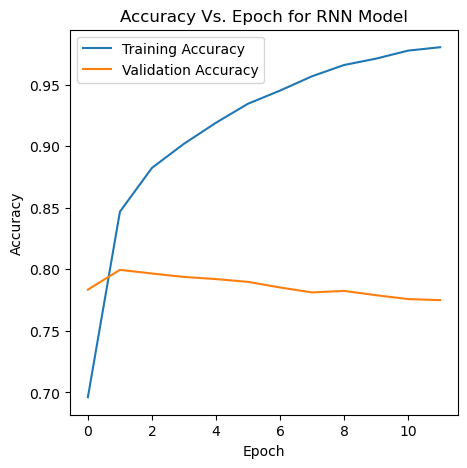

In [29]:
plt.figure(figsize=(5, 5))
plt.plot(history.history["accuracy"], zorder = 0, label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], zorder = 1, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs. Epoch for RNN Model")
plt.show()

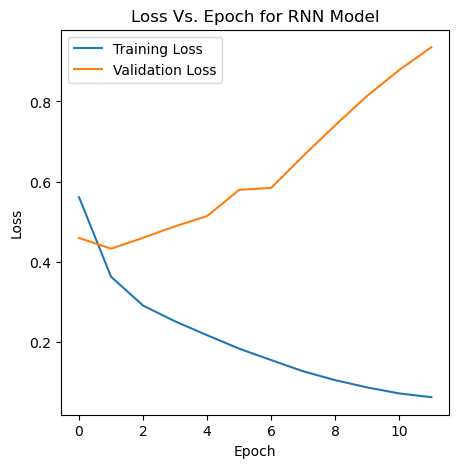

In [30]:
plt.figure(figsize=(5, 5))
plt.plot(history.history["loss"], zorder = 0, label = "Training Loss")
plt.plot(history.history["val_loss"], zorder = 1, label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Vs. Epoch for RNN Model")
plt.show()

In [31]:
#Predict for test set
y_pred = model.predict(padded_test).round()

print(metrics.classification_report(y_test, y_pred))

179/179 [==============================] - 6s 27ms/step
              precision    recall  f1-score   support

           0       0.77      0.80      0.79      2951
           1       0.78      0.74      0.76      2773

    accuracy                           0.77      5724
   macro avg       0.78      0.77      0.77      5724
weighted avg       0.78      0.77      0.77      5724



In [78]:
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))
print(metrics.recall_score(y_test, y_pred))

0.7749825296995109
0.7813565744600227
0.7435989902632528


#### Model Commentary

The above model has a high training accuracy of 98%, however the validation accuracy remains at around 77%. Also, the training loss decreases with each epoch while the validation loss increases greatly. It seems that creating our own word embeddings using the Embedding Layer isn't a good idea for this set of data. We will see if the model does better when using pre-trained word embeddings.

### Using Pre-Trained Word Embeddings

For our next model, we will use a popular pre-trained word embeddings called GloVe. GloVe stands for Global Vectors for word representation. It is an unsupervised learning algorithm developed by Stanford researchers for obtaining vector representations for words. The basic concept of this algorithm is to derive the relationship between words using statistics. It uses a co-occurrence matrix tells you how often a particular word pair occurs together. 

Reference: 
1. https://nlp.stanford.edu/projects/glove/
2. https://analyticsindiamag.com/hands-on-guide-to-word-embeddings-using-glove/

In [32]:
# import zipfile
# with zipfile.ZipFile("Downloads/glove.6B.zip","r") as zip_ref:
#     zip_ref.extractall("C:/Users/venuk/Desktop/dtsa-5511/week6")

In [33]:
#https://www.geeksforgeeks.org/pre-trained-word-embedding-using-glove-in-nlp-models/
def embedding_for_vocab(filepath, word_index,embedding_dim):
    vocab_size = len(word_index) + 1
      
    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size, embedding_dim))
  
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
  
    return embedding_matrix_vocab

# matrix for vocab: word_index
embedding_dim = 100
embedding_matrix_vocab = embedding_for_vocab(
    'C:/Users/venuk/Desktop/dtsa-5511/week6/glove.6B.100d.txt', t.word_index,
  embedding_dim)
  
print("Dense vector for first word is => ",
      embedding_matrix_vocab[1])

Dense vector for first word is =>  [-0.15730999 -0.75502998  0.36844999 -0.18957999 -0.16896001 -0.23157001
 -0.22657999 -0.30186     0.24372     0.61896002  0.58995003  0.047638
 -0.055164   -0.70210999  0.22084001 -0.69231999  0.49419001  1.42850006
 -0.25362     0.20031001 -0.26192001  0.05315    -0.048418   -0.44982001
  0.54644001 -0.014645   -0.015531   -0.61197001 -0.91964    -0.75279999
  0.64842999  1.0934      0.052682    0.33344999  0.10532     0.59517002
  0.023104   -0.37105     0.29749    -0.23683     0.079566   -0.10326
  0.35885    -0.28935    -0.19881     0.22908001 -0.061435    0.56127
 -0.017115   -0.32868001 -0.78416997 -0.49375001  0.34944001  0.16278
 -0.061168   -1.31060004  0.39151999  0.124      -0.20873    -0.18472999
 -0.56184     0.55693001  0.012114   -0.54544997 -0.31409001  0.1
  0.31542999  0.74756998 -0.47734001 -0.18332    -0.65622997  0.40768
 -0.30697    -0.47246999 -0.7421     -0.44977999 -0.078122   -0.52673
 -0.70633     1.32710004  0.26298001 -0.

In [69]:
# define model 
model_glove = tf.keras.models.Sequential()
model_glove.add(tf.keras.layers.Embedding(embedding_matrix_vocab.shape[0], output_dim = 100, input_length = max_length, 
                          weights=[embedding_matrix_vocab], trainable=True)),
model_glove.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
model_glove.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model_glove.add(tf.keras.layers.Dense(128, activation = 'relu'))
model_glove.add(tf.keras.layers.Dropout(0.5))
model_glove.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# compile model
model_glove.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics = ['accuracy'])

# summarize model
model_glove.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 99, 100)           2256400   
                                                                 
 bidirectional_18 (Bidirecti  (None, 99, 128)          84480     
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 128)               8320      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                

In [70]:
#fit model
glove_hist = model_glove.fit(padded_train,y_train, validation_data=(padded_test,y_test), epochs = 100, callbacks=[early_stopping])

Epoch 1/100
716/716 [==============================] - 123s 164ms/step - loss: 0.6192 - accuracy: 0.6520 - val_loss: 0.5469 - val_accuracy: 0.7269
Epoch 2/100
716/716 [==============================] - 116s 162ms/step - loss: 0.5120 - accuracy: 0.7519 - val_loss: 0.4990 - val_accuracy: 0.7594
Epoch 3/100
716/716 [==============================] - 116s 161ms/step - loss: 0.4585 - accuracy: 0.7872 - val_loss: 0.4644 - val_accuracy: 0.7816
Epoch 4/100
716/716 [==============================] - 119s 166ms/step - loss: 0.4131 - accuracy: 0.8127 - val_loss: 0.4547 - val_accuracy: 0.7860
Epoch 5/100
716/716 [==============================] - 113s 158ms/step - loss: 0.3766 - accuracy: 0.8339 - val_loss: 0.4292 - val_accuracy: 0.8022
Epoch 6/100
716/716 [==============================] - 116s 162ms/step - loss: 0.3438 - accuracy: 0.8527 - val_loss: 0.4308 - val_accuracy: 0.8042
Epoch 7/100
716/716 [==============================] - 115s 161ms/step - loss: 0.3156 - accuracy: 0.8684 - val_loss: 0

### Results and Analysis

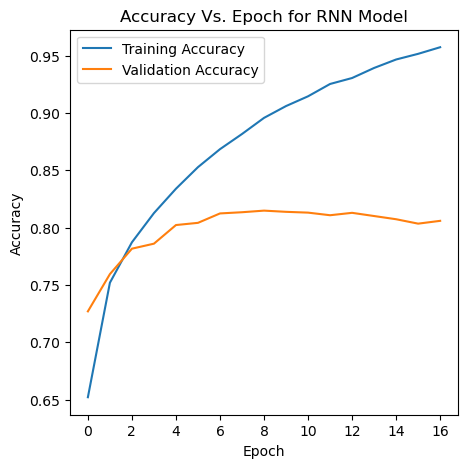

In [71]:
plt.figure(figsize=(5, 5))
plt.plot(glove_hist.history["accuracy"], zorder = 0, label = "Training Accuracy")
plt.plot(glove_hist.history["val_accuracy"], zorder = 1, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs. Epoch for RNN Model")
plt.show()

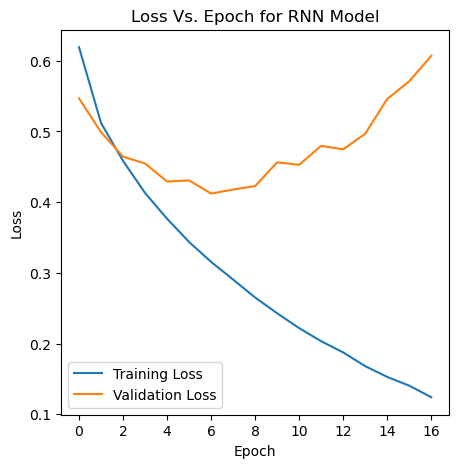

In [72]:
plt.figure(figsize=(5, 5))
plt.plot(glove_hist.history["loss"], zorder = 0, label = "Training Loss")
plt.plot(glove_hist.history["val_loss"], zorder = 1, label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Vs. Epoch for RNN Model")
plt.show()

In [73]:
#Predict for test set
yhat = model_glove.predict(padded_test).round()

print(metrics.classification_report(y_test, yhat))

179/179 [==============================] - 7s 32ms/step
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      2951
           1       0.81      0.79      0.80      2773

    accuracy                           0.81      5724
   macro avg       0.81      0.81      0.81      5724
weighted avg       0.81      0.81      0.81      5724



In [74]:
print(metrics.accuracy_score(y_test, yhat))
print(metrics.precision_score(y_test, yhat))
print(metrics.recall_score(y_test, yhat))

0.805904961565339
0.805514705882353
0.7901190046880635


#### Model Commentary

The RNN Model using GloVe word embeddings does better than the previous model. The accuracy, precision and recall are much better in this model. The validation accuracy increased to 81%. Although the validation loss is still high, it is still less than the previous model. Let's do some hyperparameter tuning to see if we can improve the results.

## Hyperparameter Tuning

I will test various learning rates in range (1e-5 to 2e-5) for the optimizer and different dropout rates to see if the model improves. The last hyperparameter I will change is the trainable parameter. If the trainable=True, it allows for the weights of embedding matrix to update during training. If it is false, it doesn't allow the weights to update during training.

In [60]:
# define model 
model_glove1 = tf.keras.models.Sequential()
model_glove1.add(tf.keras.layers.Embedding(embedding_matrix_vocab.shape[0], output_dim = 100, input_length = max_length, 
                          weights=[embedding_matrix_vocab], trainable=True)),
model_glove1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
model_glove1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model_glove1.add(tf.keras.layers.Dense(64, activation = 'relu'))
model_glove1.add(tf.keras.layers.Dropout(0.2))
model_glove1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# compile model
model_glove1.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(2e-4), metrics = ['accuracy'])

# summarize model
model_glove1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 99, 100)           2256400   
                                                                 
 bidirectional_14 (Bidirecti  (None, 99, 128)          84480     
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                

In [61]:
#fit model
glove_hist1 = model_glove1.fit(padded_train,y_train, validation_data=(padded_test,y_test), epochs = 100, callbacks=[early_stopping])

Epoch 1/100
716/716 [==============================] - 117s 156ms/step - loss: 0.5716 - accuracy: 0.6969 - val_loss: 0.4996 - val_accuracy: 0.7598
Epoch 2/100
716/716 [==============================] - 108s 151ms/step - loss: 0.4504 - accuracy: 0.7925 - val_loss: 0.4489 - val_accuracy: 0.7921
Epoch 3/100
716/716 [==============================] - 114s 160ms/step - loss: 0.3815 - accuracy: 0.8289 - val_loss: 0.4269 - val_accuracy: 0.8036
Epoch 4/100
716/716 [==============================] - 114s 159ms/step - loss: 0.3290 - accuracy: 0.8615 - val_loss: 0.4111 - val_accuracy: 0.8148
Epoch 5/100
716/716 [==============================] - 111s 155ms/step - loss: 0.2858 - accuracy: 0.8808 - val_loss: 0.4179 - val_accuracy: 0.8139
Epoch 6/100
716/716 [==============================] - 110s 154ms/step - loss: 0.2499 - accuracy: 0.9005 - val_loss: 0.4259 - val_accuracy: 0.8141
Epoch 7/100
716/716 [==============================] - 122s 171ms/step - loss: 0.2175 - accuracy: 0.9170 - val_loss: 0

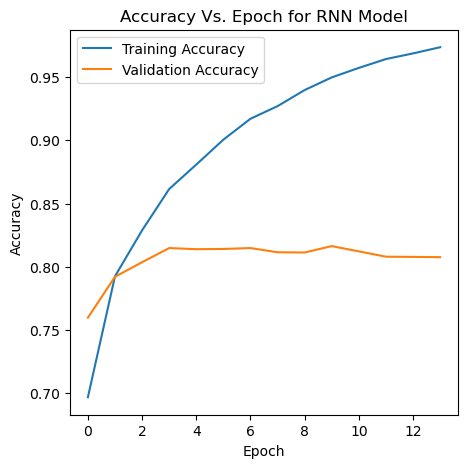

In [62]:
plt.figure(figsize=(5, 5))
plt.plot(glove_hist1.history["accuracy"], zorder = 0, label = "Training Accuracy")
plt.plot(glove_hist1.history["val_accuracy"], zorder = 1, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs. Epoch for RNN Model")
plt.show()

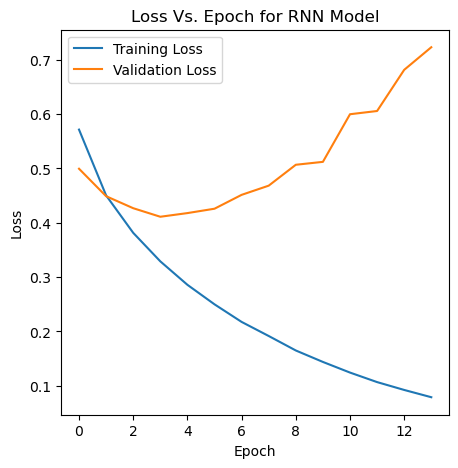

In [63]:
plt.figure(figsize=(5, 5))
plt.plot(glove_hist1.history["loss"], zorder = 0, label = "Training Loss")
plt.plot(glove_hist1.history["val_loss"], zorder = 1, label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Vs. Epoch for RNN Model")
plt.show()

In [64]:
#Predict for test set
yhat1 = model_glove1.predict(padded_test).round()

print(metrics.classification_report(y_test, yhat1))

179/179 [==============================] - 6s 31ms/step
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      2951
           1       0.82      0.78      0.80      2773

    accuracy                           0.81      5724
   macro avg       0.81      0.81      0.81      5724
weighted avg       0.81      0.81      0.81      5724



In [75]:
print(metrics.accuracy_score(y_test, yhat1))
print(metrics.precision_score(y_test, yhat1))
print(metrics.recall_score(y_test, yhat1))

0.8076519916142557
0.8152337858220211
0.7796610169491526


#### Model Commentary

After hyperparameter tuning, the model performs better than the previous one. The best learning rate is 2e-4, dropout_rate of 0.2 and dense layer units of 64. The model achieved an accuracy of 81%. 

## Conclusion

In this project, I've built RNN models for text classification. In one model architecture, I've created my own word embeddings by using the Embedding Layer. The model achieved a 77% accuracy. In the other model architecture, I've used GloVe which is a pre-trained word embeddings. The model was able to achieve a 81% accuracy. After hyperparameter tuning, I came to the conclusion that the learning rate 2e-4 was the best. Allowing the weights to be updated during training also improved model accuracy. Using the dropout rate 0.2 and 64 units in the first dense layer also improved model performance.

In future works, I would like to train an RNN network using GRU layers to see if it give a better performance than bidirectional layers. For further research into sarcasm detection, I would like to use other text datasets from Twitter or other content.

## References

1. https://www.tensorflow.org/text/tutorials/text_classification_rnn
2. https://www.kaggle.com/code/parulpandey/getting-started-with-nlp-a-general-intro
3. https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
4. https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells
5. https://www.kaggle.com/code/astraz93/beginners-tokenization-stemming-and-lemmatization
6. https://towardsdatascience.com/text-preprocessing-in-natural-language-processing-using-python-6113ff5decd8
7. https://www.kaggle.com/code/daotan/tweet-analysis-using-lstm
8. https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce
9. https://colab.research.google.com/drive/1CVZ4NTO3NRYNDV1MWxvx5Y5HKtgt0OCo#scrollTo=b537E9We_LWi
10. https://www.kaggle.com/code/abdulbasitniazi/word2vec-glove-a-beginner-s-guide
11. https://keras.io/examples/nlp/pretrained_word_embeddings/